# Mediere Spatio-Temporala

Video: 1920x1080 @ 23.976023976023978 FPS

Incepem procesarea si calculul metricilor...
Frame 10: PSNR Clean=20.39 dB | SSIM Clean=0.6235
Frame 20: PSNR Clean=20.68 dB | SSIM Clean=0.6597
Frame 30: PSNR Clean=22.35 dB | SSIM Clean=0.7039
Frame 40: PSNR Clean=22.55 dB | SSIM Clean=0.6236
Frame 50: PSNR Clean=18.85 dB | SSIM Clean=0.6717
Frame 60: PSNR Clean=22.07 dB | SSIM Clean=0.6884
Frame 70: PSNR Clean=21.90 dB | SSIM Clean=0.6817
Frame 80: PSNR Clean=20.78 dB | SSIM Clean=0.7011
Frame 90: PSNR Clean=18.97 dB | SSIM Clean=0.7013
Frame 100: PSNR Clean=21.39 dB | SSIM Clean=0.7460
Frame 110: PSNR Clean=20.03 dB | SSIM Clean=0.7531
Frame 120: PSNR Clean=20.26 dB | SSIM Clean=0.7466
Frame 130: PSNR Clean=20.49 dB | SSIM Clean=0.6817
Frame 140: PSNR Clean=25.44 dB | SSIM Clean=0.6963
Frame 150: PSNR Clean=19.40 dB | SSIM Clean=0.6486
Frame 160: PSNR Clean=22.33 dB | SSIM Clean=0.7341
Frame 170: PSNR Clean=22.03 dB | SSIM Clean=0.6861
Frame 180: PSNR Clean=21.61 dB | SSIM Clean=0.6796
Fra

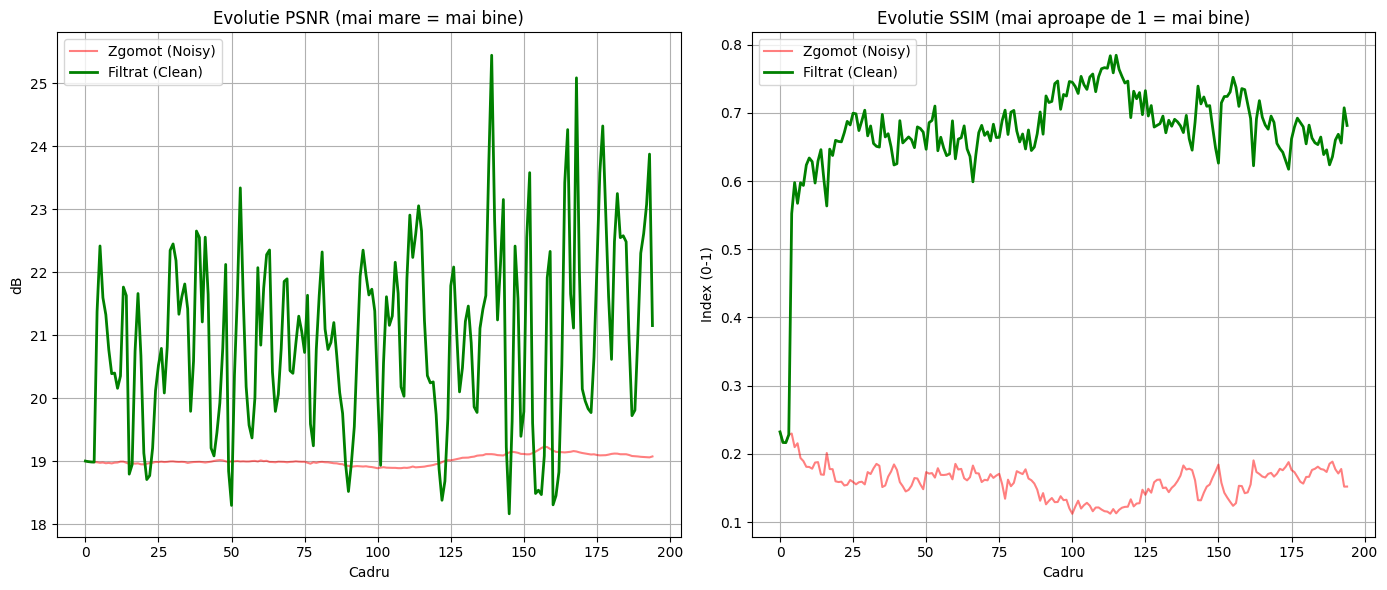

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import numpy as np
from collections import deque
import os
from google.colab import files
import matplotlib.pyplot as plt

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

class SpatioTemporalBoxFilterColor:
    def __init__(self, temporal_radius=2, spatial_radius=2):
        self.T = temporal_radius
        self.R = spatial_radius
        self.buffer_size = 2 * self.T + 1
        self.frames_buffer = deque(maxlen=self.buffer_size)

    def process_frame(self, frame):
        frame_float = frame.astype(np.float32)
        self.frames_buffer.append(frame_float)

        if len(self.frames_buffer) < self.buffer_size:
            return frame

        temporal_mean = np.mean(self.frames_buffer, axis=0)
        kernel_size = 2 * self.R + 1

        spatial_temporal_mean = cv2.blur(temporal_mean, (kernel_size, kernel_size))

        return np.uint8(np.clip(spatial_temporal_mean, 0, 255))

def main_with_metrics():

    out_noise_name = 'rezultat_zgomot.avi'
    out_clean_name = 'rezultat_filtrat.avi'

    FRAMES_LIMIT = 200

    existing_files = [f for f in os.listdir('.') if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    if len(existing_files) > 0:
        video_filename = existing_files[0]
    else:
        uploaded = files.upload()
        if not uploaded: return
        video_filename = list(uploaded.keys())[0]

    cap = cv2.VideoCapture(video_filename)

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0 or np.isnan(fps): fps = 24.0

    print(f"Video: {width}x{height} @ {fps} FPS")

    fourcc = cv2.VideoWriter_fourcc(*'MJPG')

    writer_noise = cv2.VideoWriter(out_noise_name, fourcc, fps, (width, height))
    writer_clean = cv2.VideoWriter(out_clean_name, fourcc, fps, (width, height))

    st_filter = SpatioTemporalBoxFilterColor(temporal_radius=2, spatial_radius=2)
    frame_idx = 0

    metrics = {
        'psnr_noisy': [], 'ssim_noisy': [],
        'psnr_clean': [], 'ssim_clean': []
    }

    print("\nIncepem procesarea si calculul metricilor")

    while True:
        if frame_idx >= FRAMES_LIMIT:
            break

        ret, frame = cap.read()
        if not ret: break

        # Adaugare zgomot
        noise = np.random.normal(0, 30, frame.shape).astype(np.int16)
        frame_noisy = np.clip(frame.astype(np.int16) + noise, 0, 255).astype(np.uint8)

        # Filtrare
        filtered_frame = st_filter.process_frame(frame_noisy)

        # Scriere video
        writer_noise.write(frame_noisy)
        writer_clean.write(filtered_frame)

        # PSNR
        val_psnr_noisy = psnr(frame, frame_noisy, data_range=255)
        val_psnr_clean = psnr(frame, filtered_frame, data_range=255)

        # SSIM
        val_ssim_noisy = ssim(frame, frame_noisy, data_range=255, channel_axis=-1)
        val_ssim_clean = ssim(frame, filtered_frame, data_range=255, channel_axis=-1)

        metrics['psnr_noisy'].append(val_psnr_noisy)
        metrics['psnr_clean'].append(val_psnr_clean)
        metrics['ssim_noisy'].append(val_ssim_noisy)
        metrics['ssim_clean'].append(val_ssim_clean)

        frame_idx += 1
        if frame_idx % 10 == 0:
            print(f"Frame {frame_idx}: PSNR Clean={val_psnr_clean:.2f} dB | SSIM Clean={val_ssim_clean:.4f}")

    cap.release()
    writer_noise.release()
    writer_clean.release()

    avg_psnr_n = np.mean(metrics['psnr_noisy'])
    avg_psnr_c = np.mean(metrics['psnr_clean'])
    avg_ssim_n = np.mean(metrics['ssim_noisy'])
    avg_ssim_c = np.mean(metrics['ssim_clean'])

    print("-" * 50)
    print(f"REZULTATE MEDII ({frame_idx} cadre):")
    print(f"Zgomot  -> PSNR: {avg_psnr_n:.2f} dB, SSIM: {avg_ssim_n:.4f}")
    print(f"Filtrat -> PSNR: {avg_psnr_c:.2f} dB, SSIM: {avg_ssim_c:.4f}")
    print(f"Imbunatatire PSNR: +{avg_psnr_c - avg_psnr_n:.2f} dB")
    print("-" * 50)

    plt.figure(figsize=(14, 6))

    # Grafic PSNR
    plt.subplot(1, 2, 1)
    plt.plot(metrics['psnr_noisy'], label='Zgomot (Noisy)', color='red', alpha=0.5)
    plt.plot(metrics['psnr_clean'], label='Filtrat (Clean)', color='green', linewidth=2)
    plt.title('Evolutie PSNR (mai mare = mai bine)')
    plt.xlabel('Cadru')
    plt.ylabel('dB')
    plt.legend()
    plt.grid(True)

    # Grafic SSIM
    plt.subplot(1, 2, 2)
    plt.plot(metrics['ssim_noisy'], label='Zgomot (Noisy)', color='red', alpha=0.5)
    plt.plot(metrics['ssim_clean'], label='Filtrat (Clean)', color='green', linewidth=2)
    plt.title('Evolutie SSIM (mai aproape de 1 = mai bine)')
    plt.xlabel('Cadru')
    plt.ylabel('Index (0-1)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    files.download(out_noise_name)
    files.download(out_clean_name)

main_with_metrics()

# Filtru Gaussian

In [ ]:
import cv2
import numpy as np
from collections import deque
import os
from google.colab import files

class SpatioTemporalGaussianFilter:
    def __init__(self, temporal_radius=2, spatial_radius=2, sigma_t=1.5, sigma_s=1.5):
        self.T = temporal_radius
        self.R = spatial_radius
        self.sigma_t = sigma_t
        self.sigma_s = sigma_s

        self.buffer_size = 2 * self.T + 1
        self.frames_buffer = deque(maxlen=self.buffer_size)

        # Generam o curba Gaussiana 1D
        self.temporal_weights = self._generate_1d_gaussian_kernel(self.T, self.sigma_t)
        print(f"Ponderi Temporale (Kernel): {self.temporal_weights}")

    def _generate_1d_gaussian_kernel(self, radius, sigma):
        x = np.arange(-radius, radius + 1)

        kernel = np.exp(-(x**2) / (2 * (sigma**2)))

        kernel /= kernel.sum()
        return kernel

    def process_frame(self, frame):
        frame_float = frame.astype(np.float32)
        self.frames_buffer.append(frame_float)

        if len(self.frames_buffer) < self.buffer_size:
            return frame

        # Filtrare temporala gaussiana
        temporal_gaussian = np.average(self.frames_buffer, axis=0, weights=self.temporal_weights)

        # Filtrare spatiala gaussiana
        ksize = (2 * self.R + 1, 2 * self.R + 1)

        spatial_temporal_gaussian = cv2.GaussianBlur(temporal_gaussian, ksize, self.sigma_s)

        return np.uint8(np.clip(spatial_temporal_gaussian, 0, 255))

def main_gaussian():
    video_filename = 'input.mp4'
    out_name = 'rezultat_gaussian.avi'
    FRAMES_LIMIT = 200

    existing_files = [f for f in os.listdir('.') if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    if len(existing_files) > 0:
        video_filename = existing_files[0]
    else:
        print("Incarca video...")
        uploaded = files.upload()
        if not uploaded: return
        video_filename = list(uploaded.keys())[0]

    cap = cv2.VideoCapture(video_filename)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0 or np.isnan(fps): fps = 24.0

    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(out_name, fourcc, fps, (width * 2, height))

    gf_filter = SpatioTemporalGaussianFilter(temporal_radius=2, spatial_radius=2, sigma_t=1.5, sigma_s=1.5)

    frame_idx = 0

    while True:
        if FRAMES_LIMIT and frame_idx >= FRAMES_LIMIT: break
        ret, frame = cap.read()
        if not ret: break

        # Adaugam zgomot
        noise = np.random.normal(0, 30, frame.shape).astype(np.int16)
        frame_noisy = np.clip(frame.astype(np.int16) + noise, 0, 255).astype(np.uint8)

        filtered_frame = gf_filter.process_frame(frame_noisy)

        combined = np.hstack((frame_noisy, filtered_frame))
        out.write(combined)

        frame_idx += 1
        if frame_idx % 20 == 0: print(f"Frame {frame_idx}...")

    cap.release()
    out.release()
    files.download(out_name)

main_gaussian()

# NLMeans

In [ ]:
import numpy as np
import cv2

def nlm_from_scratch(image, h=10, patch_size=5, search_window=15):
    pad = patch_size // 2
    search_rad = search_window // 2

    # Adaugam padding la imagine pentru a nu iesi din margini
    padded_img = np.pad(image, ((pad, pad), (pad, pad)), mode='reflect').astype(np.float64)
    result = np.zeros_like(image, dtype=np.float64)
    height, width = image.shape

    # Constanta de filtrare
    h2 = h * h

    print(f"Se proceseaza imaginea {width}x{height} pixel cu pixel")

    # Iteram prin fiecare pixel al imaginii originale
    for i in range(height):
        for j in range(width):

            # Coordonatele in imaginea cu padding
            i_pad, j_pad = i + pad, j + pad

            # Extragem patch-ul curent
            patch_ref = padded_img[i_pad-pad : i_pad+pad+1, j_pad-pad : j_pad+pad+1]

            weight_sum = 0.0
            pixel_sum = 0.0

            # Cautam in fereastra de cautare (Search Window)
            r_min = max(i - search_rad, 0)
            r_max = min(i + search_rad, height)
            c_min = max(j - search_rad, 0)
            c_max = min(j + search_rad, width)

            for r in range(r_min, r_max):
                for c in range(c_min, c_max):
                    # Coordonatele vecinului in imaginea cu padding
                    r_pad, c_pad = r + pad, c + pad

                    # Extragem patch-ul vecin
                    patch_neighbor = padded_img[r_pad-pad : r_pad+pad+1, c_pad-pad : c_pad+pad+1]

                    # Distanta Euclidiana patratica intre patch-uri
                    d2 = np.sum((patch_ref - patch_neighbor) ** 2)

                    # Calculam ponderea
                    w = np.exp(-d2 / h2)

                    weight_sum += w
                    pixel_sum += w * image[r, c]

            # Normalizam si salvam
            result[i, j] = pixel_sum / weight_sum

    return np.clip(result, 0, 255).astype(np.uint8)

img = cv2.imread('test.png', 0)
small_crop = img[0:50, 0:50]
out = nlm_from_scratch(small_crop)

# Comparare metode

In [ ]:
!pip install bm3d scikit-image

import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from google.colab import files
import os
import bm3d
from bm3d.profiles import BM3DProfile
from skimage.metrics import structural_similarity as ssim

RESIZE_WIDTH = 250
NOISE_SIGMA = 25
FRAMES_TO_PROCESS = 10
TEMPORAL_RADIUS = 2

def add_gaussian_noise(image, sigma):
    noise = np.random.normal(0, sigma, image.shape).astype(np.float32)
    noisy_image = image.astype(np.float32) + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def calculate_psnr(original, restored):
    mse = np.mean((original.astype(np.float32) - restored.astype(np.float32)) ** 2)
    if mse == 0: return 100
    return 20 * np.log10(255.0 / np.sqrt(mse))

def calculate_ssim(original, restored):
    return ssim(original, restored, data_range=255, channel_axis=-1)

class Filter2DGaussian:
    def process(self, frame):
        return cv2.GaussianBlur(frame, (5, 5), 1.5)

class FilterTemporalAverage:
    def __init__(self, radius):
        self.buffer = deque(maxlen=2*radius + 1)
    def process(self, frame):
        self.buffer.append(frame.astype(np.float32))
        if len(self.buffer) < self.buffer.maxlen: return frame
        avg = np.mean(self.buffer, axis=0)
        return np.clip(avg, 0, 255).astype(np.uint8)

class FilterNLMeansMulti:
    def __init__(self, radius):
        self.radius = radius
        self.buffer = deque(maxlen=2*radius + 1)
    def process(self, frame):
        self.buffer.append(frame)
        if len(self.buffer) < self.buffer.maxlen: return frame
        imgs = list(self.buffer)
        denoised = cv2.fastNlMeansDenoisingMulti(
            srcImgs=imgs, imgToDenoiseIndex=self.radius,
            temporalWindowSize=2*self.radius + 1, h=30.0,
            templateWindowSize=7, searchWindowSize=21
        )
        return denoised

class FilterVBM3D:
    def __init__(self, radius, sigma):
        self.radius = radius
        self.sigma = sigma
        self.buffer = deque(maxlen=2*radius + 1)

        self.profile = BM3DProfile()
        self.profile.bs_ht = 4
        self.profile.bs_wiener = 4
        self.profile.step_ht = 2

    def process(self, frame):
        self.buffer.append(frame)
        if len(self.buffer) < self.buffer.maxlen: return frame

        vol_stack = np.array(self.buffer).astype(np.float32) / 255.0
        h, w, c = frame.shape
        out_frame = np.zeros((h, w, c), dtype=np.float32)

        for channel in range(c):
            channel_data = vol_stack[:, :, :, channel]
            try:
                denoised_vol = bm3d.bm3d(
                    channel_data,
                    sigma_psd=self.sigma/255.0,
                    stage_arg=bm3d.BM3DStages.ALL_STAGES,
                    profile=self.profile
                )
                out_frame[:, :, channel] = denoised_vol[self.radius]
            except Exception as e:
                print(f"Eroare V-BM3D: {e}")
                return frame

        return np.clip(out_frame * 255.0, 0, 255).astype(np.uint8)


def run_experiment():
    possible_files = [f for f in os.listdir('.') if f.endswith('.mp4') or f.endswith('.avi')]

    if len(possible_files) > 0:
        filename = possible_files[0]
        print(f"Folosim fisierul existent: {filename}")
    else:
        print("Incarca un video")
        uploaded = files.upload()
        if not uploaded: return
        filename = list(uploaded.keys())[0]

    cap = cv2.VideoCapture(filename)

    psnr_results = {
        'Noisy': [], '3D Gaussian': [], 'Temporal Avg': [], 'NLMeans': [], 'V-BM3D': []
    }
    ssim_results = {
        'Noisy': [], '3D Gaussian': [], 'Temporal Avg': [], 'NLMeans': [], 'V-BM3D': []
    }

    # Initializare filtre
    filters = {
        '3D Gaussian': Filter2DGaussian(),
        'Temporal Avg': FilterTemporalAverage(TEMPORAL_RADIUS),
        'NLMeans': FilterNLMeansMulti(TEMPORAL_RADIUS),
        'V-BM3D': FilterVBM3D(TEMPORAL_RADIUS, NOISE_SIGMA)
    }

    frame_count = 0
    print(f"\nProcesam {FRAMES_TO_PROCESS} cadre")

    while frame_count < FRAMES_TO_PROCESS:
        ret, original_full = cap.read()
        if not ret: break

        h, w = original_full.shape[:2]
        scale = RESIZE_WIDTH / w
        original = cv2.resize(original_full, (RESIZE_WIDTH, int(h * scale)), interpolation=cv2.INTER_AREA)

        noisy = add_gaussian_noise(original, NOISE_SIGMA)

        # Calculam metricile pentru imaginea zgomotoasa
        psnr_results['Noisy'].append(calculate_psnr(original, noisy))
        ssim_results['Noisy'].append(calculate_ssim(original, noisy))

        for name, filter_obj in filters.items():
            restored = filter_obj.process(noisy)

            if frame_count >= TEMPORAL_RADIUS * 2:
                psnr_results[name].append(calculate_psnr(original, restored))
                ssim_results[name].append(calculate_ssim(original, restored))
            else:
                psnr_results[name].append(0)
                ssim_results[name].append(0)

        frame_count += 1
        print(f"Procesat cadrul {frame_count}/{FRAMES_TO_PROCESS}")

    cap.release()

    start_plot = TEMPORAL_RADIUS * 2

    print("\n" + "="*40)
    print(f"{'Metoda':<15} | {'PSNR Mediu (dB)':<15} | {'SSIM Mediu':<10}")
    print("-" * 40)

    for name in psnr_results.keys():

        valid_psnr = psnr_results[name][start_plot:]
        valid_ssim = ssim_results[name][start_plot:]

        if len(valid_psnr) > 0:
            avg_p = np.mean(valid_psnr)
            avg_s = np.mean(valid_ssim)
            print(f"{name:<15} | {avg_p:<15.2f} | {avg_s:<10.4f}")
    print("="*40 + "\n")

    plt.figure(figsize=(16, 6))
    plt.style.use('seaborn-v0_8-darkgrid')

    colors = {
        'Noisy': 'red', '3D Gaussian': 'blue',
        'Temporal Avg': 'green', 'NLMeans': 'purple',
        'V-BM3D': 'orange'
    }

    # Grafic 1: PSNR
    plt.subplot(1, 2, 1)
    for name, data in psnr_results.items():
        valid_data = data[start_plot:]
        if len(valid_data) > 0:
            plt.plot(range(start_plot, frame_count), valid_data,
                     label=f"{name}", color=colors.get(name, 'black'))
    plt.title('Comparatie PSNR')
    plt.ylabel('PSNR (dB)')
    plt.xlabel('Index Cadru')
    plt.legend()
    plt.grid(True)

    # Grafic 2: SSIM
    plt.subplot(1, 2, 2)
    for name, data in ssim_results.items():
        valid_data = data[start_plot:]
        if len(valid_data) > 0:
            plt.plot(range(start_plot, frame_count), valid_data,
                     label=f"{name}", color=colors.get(name, 'black'))
    plt.title('Comparatie SSIM')
    plt.ylabel('SSIM (0.0 - 1.0)')
    plt.xlabel('Index Cadru')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

run_experiment()